In [2]:
# %%time
# %pip install pandas numpy matplotlib scikit-learn
# %pip install torch==2.8.0+cpu torchvision==0.23.0+cpu torchaudio==2.8.0+cpu \
#     --index-url https://download.pytorch.org/whl/cpu

# !pip install pandas==2.2.2
# !pip install numpy==1.26.4
# !pip install matplotlib==3.8.0
# !pip install scikit-learn==1.5.0
# !pip install torch==2.3.1
# !pip install torchvision==0.18.1

# !pip install kagglehub

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
from PIL import Image
import kagglehub

In [4]:
import io

def load_images_from_folders(base_path):
    actors = [
        'Angelina Jolie', 'Brad Pitt', 'Denzel Washington', 
        'Hugh Jackman', 'Jennifer Lawrence', 'Johnny Depp',
        'Kate Winslet', 'Leonardo DiCaprio', 'Megan Fox',
        'Natalie Portman', 'Nicole Kidman', 'Robert Downey Jr',
        'Sandra Bullock', 'Scarlett Johansson', 'Tom Cruise',
        'Tom Hanks', 'Will Smith'
    ]
    
    # find the correct subdirectory containing actor folders
    for item in os.listdir(base_path):
        full_path = os.path.join(base_path, item)
        if os.path.isdir(full_path) and any(actor in os.listdir(full_path) for actor in ['Angelina Jolie', 'Brad Pitt']):
            base_path = full_path
            break
    
    images = {actor.replace(' ', '_').lower(): [] for actor in actors}
    
    # Load images from each actor's folder and process them
    for actor in actors:
        actor_path = os.path.join(base_path, actor)
        if os.path.exists(actor_path):
            for image_file in os.listdir(actor_path):
                if image_file.lower().endswith('.jpg'):
                    try:
                        img_path = os.path.join(actor_path, image_file)
                        img = Image.open(img_path).convert('RGB')
                        images[actor.replace(' ', '_').lower()].append(np.array(img))
                    except Exception as e:
                        print(f"Error loading {image_file} for {actor}: {str(e)}")
    
    return images


# Download latest version of the dataset from Kaggle
path = kagglehub.dataset_download("vishesh1412/celebrity-face-image-dataset")
print("Path to dataset files:", path)
images = load_images_from_folders(path)

Path to dataset files: /Users/adrian/.cache/kagglehub/datasets/vishesh1412/celebrity-face-image-dataset/versions/1


In [5]:
# Print the number of images per actor
for actor, actor_images in images.items():
    print(f"Number of images for {actor}: {len(actor_images)}")

Number of images for angelina_jolie: 100
Number of images for brad_pitt: 100
Number of images for denzel_washington: 100
Number of images for hugh_jackman: 100
Number of images for jennifer_lawrence: 100
Number of images for johnny_depp: 100
Number of images for kate_winslet: 100
Number of images for leonardo_dicaprio: 100
Number of images for megan_fox: 100
Number of images for natalie_portman: 100
Number of images for nicole_kidman: 100
Number of images for robert_downey_jr: 100
Number of images for sandra_bullock: 100
Number of images for scarlett_johansson: 200
Number of images for tom_cruise: 100
Number of images for tom_hanks: 100
Number of images for will_smith: 100


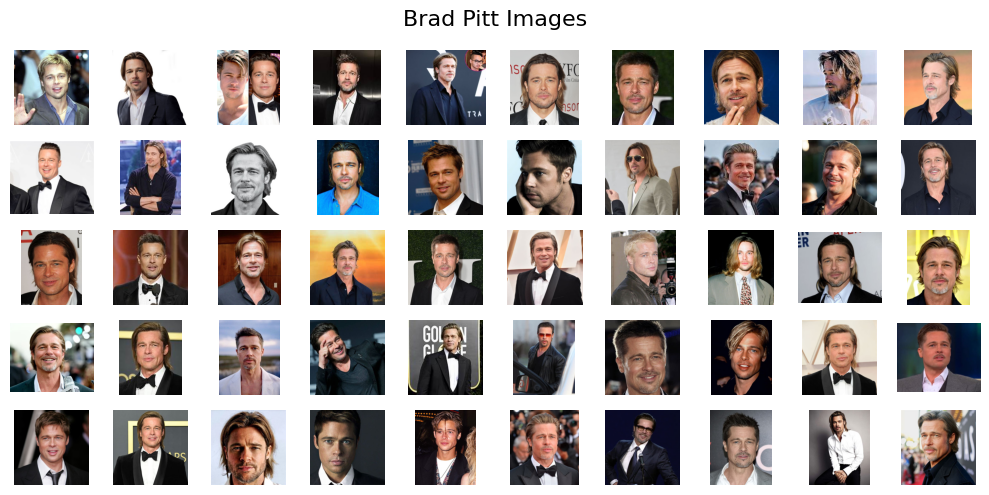

In [ ]:
def plot_images(images, title):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img, ax in zip(images, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot images from Brad Pitt
plot_images(images['brad_pitt'], 'Brad Pitt Images')

In [ ]:
class ActorDataset(Dataset):
    def __init__(self, images, transform=None, classes=None):
        self.images = []
        self.labels = []
        self.transform = transform
        self.classes = classes
        
        for label, class_name in enumerate(self.classes):
            for img in images[class_name]:
                self.images.append(img)
                self.labels.append(label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),                 # looks like 224 works best for pretrained nets
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # imagenet mean/std for transfer learning
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
dataset = ActorDataset(images, transform=transform, classes=['angelina_jolie', 'brad_pitt', 'denzel_washington', 'hugh_jackman', 'jennifer_lawrence', 'johnny_depp', 'kate_winslet', 'leonardo_dicaprio', 'megan_fox', 'natalie_portman', 'nicole_kidman', 'robert_downey_jr', 'sandra_bullock', 'scarlett_johansson', 'tom_cruise', 'tom_hanks', 'will_smith', ])


In [8]:
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Generate a list of indices for the entire dataset
indices = list(range(len(dataset)))

# Split the indices into training and validation sets
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=seed)

# Create samplers for training and validation sets
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

# Create DataLoader objects for training and validation sets
train_loader = DataLoader(dataset, batch_size=8, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=20, sampler=val_sampler)

# Print the sizes of the training and validation sets
print("Train size:", len(train_indices))
print("Validation size:", len(val_indices))

Train size: 1440
Validation size: 360


In [9]:
# import torch.nn as nn
# import torch.nn.functional as F

# # Define a custom CNN model
# class ActorCNN(nn.Module):
#     def __init__(self):
#         super(ActorCNN, self).__init__()
#         # Add padding=1 to maintain the border
#         self.conv1 = nn.Conv2d(3, 32, 3, 1, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(64 * 16 * 16, 128)
#         self.fc2 = nn.Linear(128, 17)
        
#     def forward(self, x):
#         x = self.pool(F.leaky_relu(self.conv1(x)))
#         x = self.pool(F.leaky_relu(self.conv2(x)))
#         x = x.view(-1, 64 * 16 * 16)
#         x = F.leaky_relu(self.fc1(x))
#         x = self.fc2(x)
#         return x

# # Instantiate the model
# model = ActorCNN()


import torchvision.models as models

num_classes = 17  # number of actors used in your classes list
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Using device:", device)
# attempt to load pretrained weights if available
try:
    base = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
except Exception:
    base = models.resnet34(pretrained=True)

# replace final layer
base.fc = nn.Linear(base.fc.in_features, num_classes)
model = base.to(device)

# Unfreeze last two blocks + fc
for name, param in model.named_parameters():
    if "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False


Using device: mps


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /Users/adrian/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 55.9MB/s]


In [10]:
# Vizualize the model architecture
print(model)

# See the tensor sizes at each layer
input_tensor = torch.randn(1, 3, 64, 64)

print("\nTensor shapes:\n")
# Just visualize layer shapes once
def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")

hooks = []
for layer in model.children():
    hooks.append(layer.register_forward_hook(print_size))

# Pass dummy data
with torch.no_grad():
    dummy = torch.randn(1, 3, 224, 224).to(device)
    _ = model(dummy)

# Remove hooks immediately
for h in hooks:
    h.remove()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# LR scheduler: reduce LR by factor 0.1 every 5 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [12]:
import matplotlib.pyplot as plt
import torch

# Training loop
num_epochs = 15
train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.long()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)
    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()
    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} , LR: {current_lr:.6f}')

print('Finished Training')



Epoch 1, Train Loss: 2.1563, Val Loss: 1.9845 , LR: 0.001000
Epoch 2, Train Loss: 1.5548, Val Loss: 1.3996 , LR: 0.001000
Epoch 3, Train Loss: 1.2466, Val Loss: 1.4848 , LR: 0.001000
Epoch 4, Train Loss: 1.0464, Val Loss: 1.0485 , LR: 0.001000
Epoch 5, Train Loss: 0.8832, Val Loss: 1.1985 , LR: 0.001000
Epoch 6, Train Loss: 0.5855, Val Loss: 0.8830 , LR: 0.000100
Epoch 7, Train Loss: 0.4458, Val Loss: 0.7837 , LR: 0.000100
Epoch 8, Train Loss: 0.4333, Val Loss: 0.7847 , LR: 0.000100
Epoch 9, Train Loss: 0.3631, Val Loss: 0.7738 , LR: 0.000100
Epoch 10, Train Loss: 0.3280, Val Loss: 0.7391 , LR: 0.000100
Epoch 11, Train Loss: 0.2913, Val Loss: 0.7096 , LR: 0.000010
Epoch 12, Train Loss: 0.3006, Val Loss: 0.7746 , LR: 0.000010
Epoch 13, Train Loss: 0.2946, Val Loss: 0.7813 , LR: 0.000010
Epoch 14, Train Loss: 0.2717, Val Loss: 0.7305 , LR: 0.000010
Epoch 15, Train Loss: 0.3118, Val Loss: 0.7653 , LR: 0.000010
Finished Training


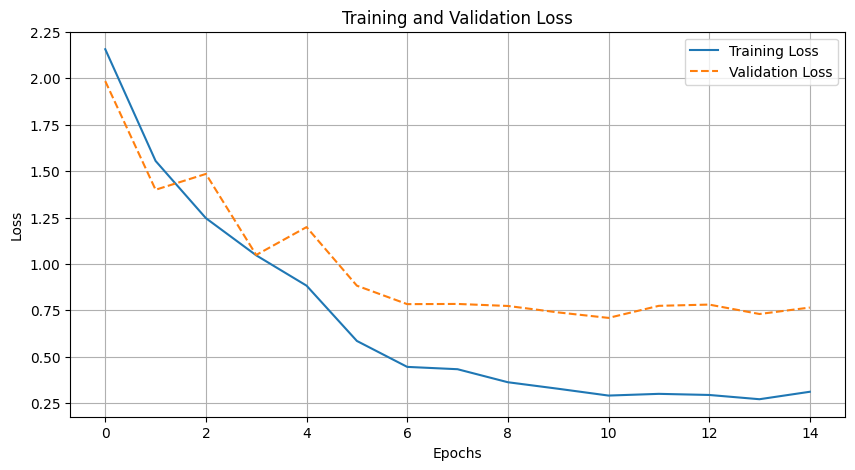

In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Validation Loss')
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

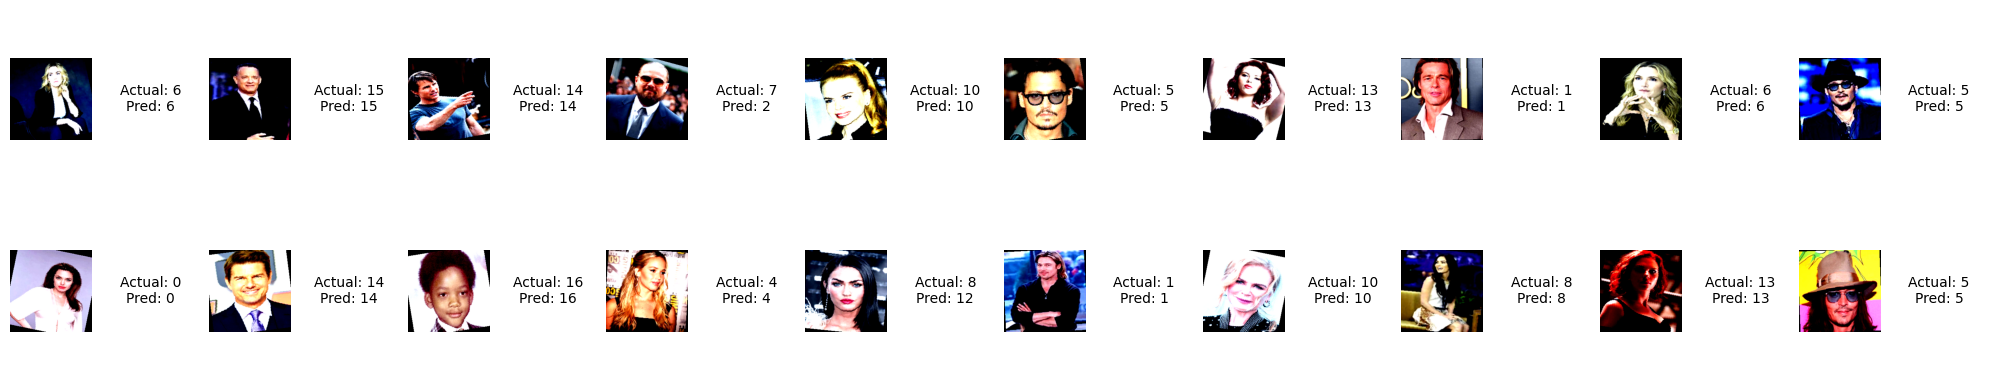

In [14]:
def imshow(img, ax):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

model.eval()
data_iter = iter(val_loader)
images_batch, labels = next(data_iter)

outputs = model(images_batch.to(device))
_, predicted = torch.max(outputs, 1)

num_images = len(images_batch)
if num_images == 0:
    print("No images in validation batch.")
else:
    cols = min(10, num_images)
    rows = (num_images + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols * 2, figsize=(cols * 2, rows * 2))
    # normalize axs to 2D array
    if rows == 1:
        axs = np.expand_dims(axs, 0)
    axs = np.atleast_2d(axs)

    for idx in range(num_images):
        row = idx // cols
        col = (idx % cols) * 2

        im_ax = axs[row, col]
        txt_ax = axs[row, col + 1]

        imshow(images_batch[idx].cpu(), im_ax)
        txt_ax.text(0.5, 0.5, f"Actual: {labels[idx].item()}\nPred: {predicted[idx].item()}",
                    horizontalalignment='center', verticalalignment='center', fontsize=10)
        txt_ax.axis('off')

    # turn off any unused axes
    total_slots = rows * cols
    for idx in range(num_images, total_slots):
        row = idx // cols
        col = (idx % cols) * 2
        axs[row, col].axis('off')
        axs[row, col + 1].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
correct = 0
total = 0

# Compute overall accuracy
with torch.no_grad():
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'correct: {correct}, total: {total}')

print(f'Validation Accuracy: {100 * correct / total:.2f}%')

correct: 17, total: 20
correct: 32, total: 40
correct: 49, total: 60
correct: 66, total: 80
correct: 81, total: 100
correct: 96, total: 120
correct: 113, total: 140
correct: 128, total: 160
correct: 145, total: 180
correct: 159, total: 200
correct: 172, total: 220
correct: 186, total: 240
correct: 201, total: 260
correct: 215, total: 280
correct: 232, total: 300
correct: 246, total: 320
correct: 262, total: 340
correct: 277, total: 360
Validation Accuracy: 76.94%


In [16]:
# save the trained model
save_path = "actor_resnet18_base.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'val_accuracy': 76.94  # metadata so I don't forget
}, save_path)

print(f"Base model saved at {save_path}")


Base model saved at actor_resnet18_base.pth


In [18]:
# Unfreeze all parameters
for param in model.parameters():
    param.requires_grad = True

# Define new optimizer & scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
criterion = nn.CrossEntropyLoss()

# re-train the model (fine-tuning)
num_epochs_finetune = 5
train_losses_ft, val_losses_ft = [], []
best_acc = 0.0
for epoch in range(num_epochs_finetune):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses_ft.append(train_loss)

    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses_ft.append(val_loss)
    acc = 100 * correct / total

    scheduler.step()
    print(f"Fine-Tune {epoch+1}/{num_epochs_finetune} - Train {train_loss:.4f} | Val {val_loss:.4f} | Acc {acc:.2f}%")
    # save the best model
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "actor_resnet18_best.pth")
        print(f"Saved new best model (Acc: {best_acc:.2f}%)")

print("Fine-tuning complete!")


Fine-Tune 1/5 - Train 0.1735 | Val 0.6376 | Acc 80.83%
Saved new best model (Acc: 80.83%)
Fine-Tune 2/5 - Train 0.1837 | Val 0.6944 | Acc 78.33%
Fine-Tune 3/5 - Train 0.1851 | Val 0.6917 | Acc 79.72%
Fine-Tune 4/5 - Train 0.1922 | Val 0.7298 | Acc 80.56%
Fine-Tune 5/5 - Train 0.1715 | Val 0.7010 | Acc 78.61%
Fine-tuning complete!


<Figure size 1000x1000 with 0 Axes>

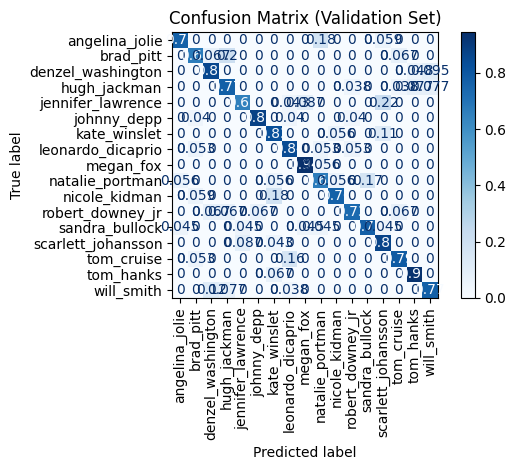

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
# Get the class names in the same order used for training
class_names = ['angelina_jolie', 'brad_pitt', 'denzel_washington', 'hugh_jackman',
               'jennifer_lawrence', 'johnny_depp', 'kate_winslet', 'leonardo_dicaprio',
               'megan_fox', 'natalie_portman', 'nicole_kidman', 'robert_downey_jr',
               'sandra_bullock', 'scarlett_johansson', 'tom_cruise', 'tom_hanks', 'will_smith']

cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, colorbar=True)
plt.title("Confusion Matrix (Validation Set)")
plt.tight_layout()
plt.show()
# Looks like the model finds Brad Pitt, Leonardo DiCaprio and Johnny Depp pretty similar so often confuses them.